In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import time
import amt.method as md
import amt.data_loader as dl
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
output_folder = '../../results/simulation'
output_figure_folder = '../../figures/figure_simu'
output_file = output_folder + '/simulation_alpha.pickle'
n_hypothesis = 1000
n_rep = 5
alpha = 0.1
n_fMC = 10000
alpha_list = [0.05, 0.1, 0.15, 0.2, 0.25]
n_param = len(alpha_list)
method_list = ['fmc', 'smc50', 'smc100', 'amt']

# Simulation

In [45]:
res_dic = {}
for method in method_list:
    res_dic[method] = {}
    res_dic[method]['n_MC_avg'] = np.zeros([n_param, n_rep], dtype=float)
    res_dic[method]['power'] = np.zeros([n_param, n_rep], dtype=float)
    res_dic[method]['fdp'] = np.zeros([n_param, n_rep], dtype=float)
    res_dic[method]['time'] = np.zeros([n_param, n_rep], dtype=float)
    
for i_alpha,alpha in enumerate(alpha_list):
    for i_rep in range(n_rep):
        print('effect=%0.2f, i_rep=%d'%(alpha,i_rep))
        # Generate ground truth
        p_exact, h = dl.load_demo_data(n_hypothesis=n_hypothesis, pi1=0.2, 
                                       effect_size=2.5, random_state=i_rep)
        tau_exact = md.bh(p_exact, alpha=alpha)
        h_exact = (p_exact <= tau_exact)
        # fMC p-values and MC samples
        start_time = time.time()
        B, p_fmc, t_fmc = md.get_monte_carlo_sample(p_exact, n_permutation=n_fMC)
        tau_fmc = md.bh(p_fmc, alpha=alpha)
        h_fmc = (p_fmc <= tau_fmc)
        res_dic['fmc']['n_MC_avg'][i_alpha,i_rep] = n_fMC
        res_dic['fmc']['power'][i_alpha,i_rep] = np.sum(h_fmc&h)/np.sum(h)
        res_dic['fmc']['fdp'][i_alpha,i_rep] = np.sum(h_fmc&(~h))/np.sum(h_fmc)
        res_dic['fmc']['time'][i_alpha,i_rep] = time.time()-start_time
        print('# fMC: avg. MC samples = %d, time=%0.2fs'%(np.mean(n_fMC),
                                                          time.time()-start_time))
        print('')
        # AMT 
        start_time = time.time()
        p_hat_ub, p_hat_lb, p_hat, tau_hat, n_amt = md.amt(md.f_sample_dummy, B, n_hypothesis,
                                          alpha=alpha, n_fMC=n_fMC,
                                          verbose=False)
        h_amt = (p_hat_ub <= tau_hat)
        res_dic['amt']['n_MC_avg'][i_alpha,i_rep] = np.mean(n_amt)
        res_dic['amt']['power'][i_alpha,i_rep] = np.sum(h_amt&h)/np.sum(h)
        res_dic['amt']['fdp'][i_alpha,i_rep] = np.sum(h_amt&(~h))/np.sum(h_amt)
        res_dic['amt']['time'][i_alpha,i_rep] = time.time()-start_time
        print('# AMT: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_amt),
                                                             time.time()-start_time))
        print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_amt, h_fmc)))
        print('')
        # smc50
        start_time = time.time()
        p_smc, n_smc = md.sMC(B, r=50)
        tau_smc = md.bh(p_smc, alpha=alpha)
        h_smc = (p_smc <= tau_smc)
        res_dic['smc50']['n_MC_avg'][i_alpha,i_rep] = np.mean(n_smc)
        res_dic['smc50']['power'][i_alpha,i_rep] = np.sum(h_smc&h)/np.sum(h)
        res_dic['smc50']['fdp'][i_alpha,i_rep] = np.sum(h_smc&(~h))/np.sum(h_smc)
        res_dic['smc50']['time'][i_alpha,i_rep] = time.time()-start_time
        print('# sMC50: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_smc),
                                                             time.time()-start_time))
        print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_smc, h_fmc)))
        print('')
        # smc100
        start_time = time.time()
        p_smc, n_smc = md.sMC(B, r=100)
        tau_smc = md.bh(p_smc, alpha=alpha)
        h_smc = (p_smc <= tau_smc)
        res_dic['smc100']['n_MC_avg'][i_alpha,i_rep] = np.mean(n_smc)
        res_dic['smc100']['power'][i_alpha,i_rep] = np.sum(h_smc&h)/np.sum(h)
        res_dic['smc100']['fdp'][i_alpha,i_rep] = np.sum(h_smc&(~h))/np.sum(h_smc)
        res_dic['smc100']['time'][i_alpha,i_rep] = time.time()-start_time
        print('# sMC100: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_smc),
                                                             time.time()-start_time))
        print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_smc, h_fmc)))
        print('')
with open(output_file, "wb") as f:
    pickle.dump(res_dic, f)    

effect=0.05, i_rep=0
# fMC: avg. MC samples = 10000, time=1.91s

# AMT: avg. MC samples = 1461.8, time=0.09s
# D_hat=92, D_overlap=92, D_full=92

# sMC50: avg. MC samples = 1464.6, time=0.19s
# D_hat=92, D_overlap=92, D_full=92

# sMC100: avg. MC samples = 1875.1, time=0.19s
# D_hat=92, D_overlap=92, D_full=92

effect=0.05, i_rep=1
# fMC: avg. MC samples = 10000, time=1.79s

# AMT: avg. MC samples = 1495.3, time=0.09s
# D_hat=107, D_overlap=107, D_full=107

# sMC50: avg. MC samples = 1561.7, time=0.18s
# D_hat=108, D_overlap=107, D_full=107

# sMC100: avg. MC samples = 1961.1, time=0.19s
# D_hat=107, D_overlap=107, D_full=107

effect=0.05, i_rep=2
# fMC: avg. MC samples = 10000, time=1.86s

# AMT: avg. MC samples = 1530.9, time=0.09s
# D_hat=86, D_overlap=86, D_full=86

# sMC50: avg. MC samples = 1474.8, time=0.19s
# D_hat=86, D_overlap=86, D_full=86

# sMC100: avg. MC samples = 1879.6, time=0.20s
# D_hat=86, D_overlap=86, D_full=86

effect=0.05, i_rep=3
# fMC: avg. MC samples = 10000,

# Generate figures

In [3]:
with open(output_file, 'rb')as f:
    res_dic = pickle.load(f)

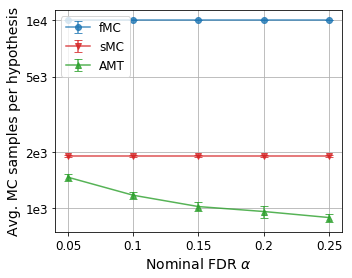

In [6]:
# Generate the figures
output_fig_file = output_figure_folder+'/figure_fdr'
# method_list = ['fmc', 'smc100', 'smc50', 'amt']
# method_dic = {'fmc':'fMC', 'smc50':'sMC (r=50)', 
#               'smc100':'sMC (r=100)', 'amt':'AMT'}
# marker_list = ['o', 'v', '^', '*', 'h', 'd']
# color_list = ['C0', 'C3', 'C1', 'C2', 'C5', 'C8']
method_list = ['fmc', 'smc100', 'amt']
method_dic = {'fmc':'fMC', 'smc50':'sMC (r=50)', 
              'smc100':'sMC', 'amt':'AMT'}
marker_list = ['o', 'v', '^', '*', 'h', 'd']
color_list = ['C0', 'C3', 'C2', 'C1', 'C5', 'C8']
# plt.figure()
plt.figure(figsize=(5,4))
for i_method,method in enumerate(method_list):
    y_val = np.mean(res_dic[method]['n_MC_avg'], axis=1)
    temp = np.std(res_dic[method]['n_MC_avg'], axis=1) / np.sqrt(n_rep) * 1.96
    y_err = np.zeros([2, n_param], dtype=float) 
    y_err[0,:] = np.log10(y_val) - np.log10(y_val-temp) 
    y_err[1,:] = np.log10(y_val+temp) - np.log10(y_val)
    plt.errorbar(alpha_list, np.log10(y_val), yerr=y_err, label=method_dic[method],\
                 capsize=4, elinewidth = 1.5, linewidth=1.5,\
                 color = color_list[i_method], marker = marker_list[i_method],\
                 markersize = 6, alpha=0.8)
# plt.yscale('log')
plt.grid()
plt.xticks(alpha_list, alpha_list, fontsize=12)
# y_val = [3, 3.25, 3.5, 3.75, 4]
y_val = [3, 3.3, 3.7, 4]
y_tick = []
for y in y_val:
    temp_str = '%0.1e'%(10**y)
#     y_tick.append(temp_str.replace('+0', ''))
    y_tick.append(temp_str.replace('+0', '').replace('.0e','e'))
plt.yticks(y_val, y_tick, rotation= 0, fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.xlabel('Nominal FDR $\\alpha$', fontsize=14)
# plt.ylabel('log10 average MC samples', fontsize=12)
plt.ylabel('Avg. MC samples per hypothesis', fontsize=14)
plt.tight_layout()
plt.savefig(output_fig_file+'.png')
plt.savefig(output_fig_file+'.pdf')
plt.show()